In [1]:
import torch
import torch.nn.functional as F


torch.manual_seed(12046)

# logits变化幅度对交叉熵的影响
clz_num = 2
num = 1000
## 当logits是标准正态分布时，交叉熵较小
logits = torch.randn(num, clz_num)
y = torch.randint(clz_num, (num,))
F.cross_entropy(logits, y)

tensor(0.9076)

In [2]:
## 将logits的幅度变大10倍，交叉熵较大
logits = torch.randn(num, clz_num) * 10
y = torch.randint(clz_num, (num,))
F.cross_entropy(logits, y)

tensor(5.7065)

In [3]:
from utils import Linear, Sigmoid, Sequential
import matplotlib.pyplot as plt
%matplotlib inline


# 为了讨论的方便，我们将神经网络扩大
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(       n_hidden, 2)
    ])

In [4]:
# 参数初始化优化
with torch.no_grad():
    for layer in model.layers:
        if isinstance(layer, Linear):
            in_features, out_features = layer.weight.shape
            # 将权重项的方差变小
            layer.weight *= 1 / in_features ** 0.5
            # 将截距项设置成0
            layer.bias = torch.zeros(out_features)
            
# 对于模型参数，需要记录它们的梯度（为反向传播做准备）
for p in model.parameters():
    p.requires_grad = True

In [5]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import numpy as np

# 生成训练数据并将数据做归一化处理
np.random.seed(12046)
data = make_moons(n_samples=2000, noise=.05)
scaler = StandardScaler()
data = (scaler.fit_transform(data[0]), data[1])

In [6]:
def train_model(max_steps):
    batch_size = 2000
    lossi = []
    # 记录各层的参数更新幅度
    udi = {}
    x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
    _prob = torch.ones(x.shape[0]) / x.shape[0]

    for i in range(max_steps):
        # 构造批次训练数据
        ## 不放回的随机抽样
        ix = _prob.multinomial(batch_size)
        xb = x[ix]
        yb = y[ix]
        # 向前传播
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        # 保留中间节点的梯度，以便观察
        for layer in model.layers:
            layer.out.retain_grad()
        for p in model.parameters():
            p.grad = None
        # 反向传播
        loss.backward()
        # 更新模型参数
        ## 学习速率衰减
        learning_rate = 0.1 if i < 20000 else 0.01
        with torch.no_grad():
            for i, p in enumerate(model.parameters()):
                p -= learning_rate * p.grad
                udi[i] = udi.get(i, []) + [(learning_rate * p.grad).std() / p.std()]
        lossi.append(loss.item())
    return lossi, udi

In [7]:
train_model(1)

([0.6942585110664368],
 {0: [tensor(1.8946e-05)],
  1: [tensor(1.)],
  2: [tensor(0.0001)],
  3: [tensor(1.)],
  4: [tensor(0.0002)],
  5: [tensor(1.)],
  6: [tensor(0.0003)],
  7: [tensor(1.)],
  8: [tensor(0.0070)],
  9: [tensor(1.)]})

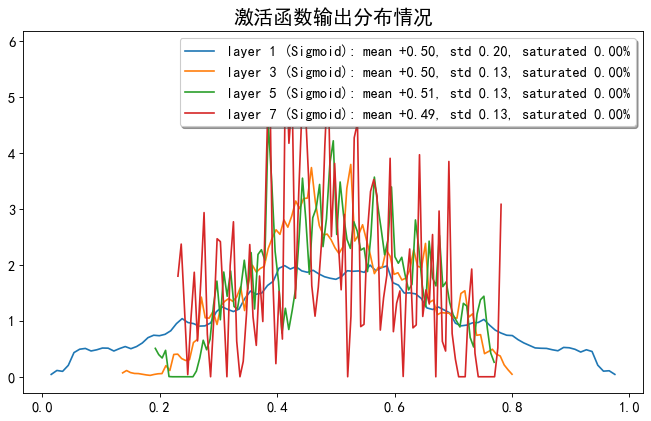

In [8]:
# 观察激活函数的状态
plt.figure(figsize=(10, 6), dpi=80)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, (Sigmoid)):
        t = layer.out
        # 激活函数的输出大于0.99或者小于0.01时，激活函数“过热”
        saturation = ((t - 0.5).abs() > 0.49).float().mean()
        # 激活函数输出的分布情况
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} ({layer.__class__.__name__})'
        stats = f'mean {t.mean():+.2f}, std {t.std():.2f}, saturated {saturation:.2%}'
        legends.append(f'{layer_name}: {stats}')
plt.legend(legends, shadow=True)
plt.title('激活函数输出分布情况', fontsize=18)
plt.savefig("normalization_activation_distribution.png", dpi=200)
plt.show()

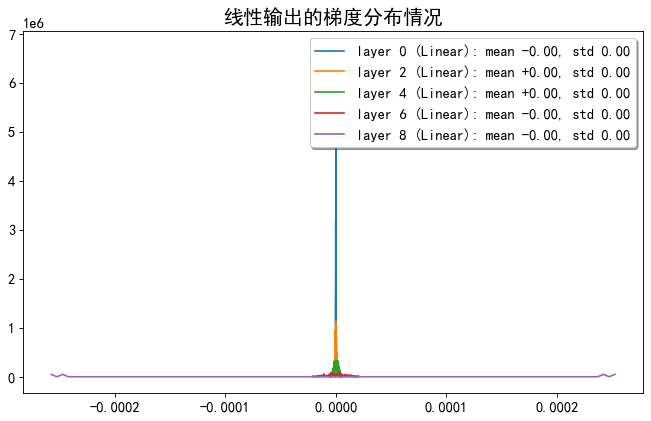

In [9]:
# 即使激活函数没有过热，但由于激活函数本身的特性，还是能观察到梯度消失的现象
plt.figure(figsize=(10, 6), dpi=80)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, (Linear)):
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} ({layer.__class__.__name__})'
        stats = f'mean {t.mean():+.2f}, std {t.std():.2f}'
        legends.append(f'{layer_name}: {stats}')
plt.legend(legends, shadow=True)
plt.title('线性输出的梯度分布情况', fontsize=18)
plt.savefig("normalization_linear_grad_distribution.png", dpi=200)
plt.show()

layer 0   (2, 100): mean -0.0000, std 0.0001, grad ratio 0.00018946
layer 2 (100, 100): mean +0.0000, std 0.0001, grad ratio 0.00135896
layer 4 (100, 100): mean +0.0000, std 0.0002, grad ratio 0.00163481
layer 6 (100, 100): mean -0.0000, std 0.0003, grad ratio 0.00302278


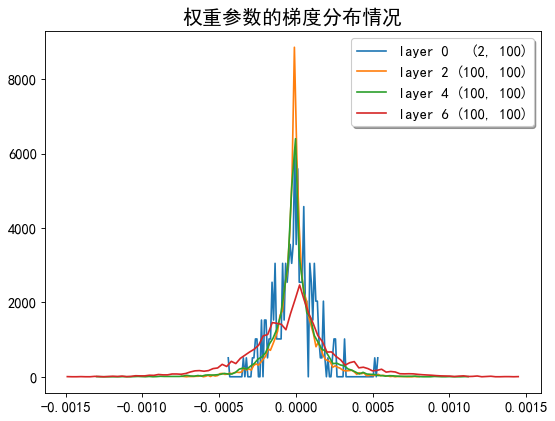

In [10]:
# 观察参数梯度的分布情况
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
legends = []
# 输出层的参数较为特殊，这里在作图时排除掉
for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, (Linear)):
        # 只观察权重参数，也就是w
        p = layer.parameters()[0]
        g = p.grad
        # 统计梯度标准差与参数标准差的比例
        grad_ratio = g.std() / p.std()
        hy, hx = torch.histogram(g, density=True)
        ax.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} {str(tuple(p.shape)):>10}'
        stats = f'mean {g.mean():+.4f}, std {g.std():.4f}, grad ratio {grad_ratio:.8f}'
        legends.append(f'{layer_name}')
        print(f'{layer_name}: {stats}')
ax.legend(legends, shadow=True)
ax.set_title('权重参数的梯度分布情况', fontsize=18)
fig.savefig("normalization_weight_grad_distribution.png", dpi=200)

In [11]:
_, ud = train_model(1000)

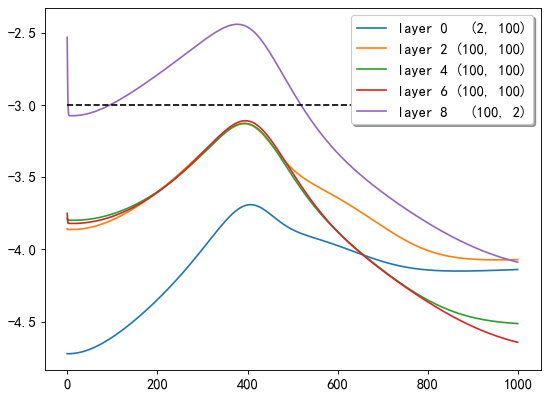

In [12]:
plt.figure(figsize=(8, 6), dpi=80)
legends = []
for i, p in enumerate(model.parameters()):
    # 只观察权重参数，也就是w
    if p.ndim == 2:
        plt.plot([t.log10().item() for t in ud[i]])
        legends.append(f'layer {i} {str(tuple(p.shape)):>10}')
# 理想的标准线
plt.plot([0, len(ud[0])], [-3, -3], 'k--')
plt.legend(legends, shadow=True)
plt.savefig("normalization_weights_grad_ratio.png", dpi=200)
plt.show()

In [13]:
@torch.no_grad()
def layer_stats(func, calculate_gain):
    """
    只做向前传播，并记录每一层输出的分布情况
    理想情况下，各层输出的方差应该保持稳定
    参数
    ----
    func : 激活函数
    calculate_gain : 函数增益
    """
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(111)
    legends = []
    x = torch.randn(300, 1000)  # 批量大小是300
    for i in range(10):
        l = Linear(1000, 1000, bias=False)
        in_features, _ = l.weight.shape
        # 做初步的优化
        l.weight *= 1 / in_features ** 0.5
        # 利用函数增益做进一步优化
        l.weight *= calculate_gain
        x = func(l(x))
        # 记录输出的分布情况
        hy, hx = torch.histogram(x, density=True)
        ax.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {str(i + 1):>2}'
        stats = f'mean {x.mean().item():+.2f}, std {x.std().item():.2f}'
        print (f'{layer_name}: {stats}')
        legends.append(f'{layer_name}: {stats}')
    return fig, legends

layer  1: mean +0.50, std 0.21
layer  2: mean +0.50, std 0.13
layer  3: mean +0.50, std 0.12
layer  4: mean +0.50, std 0.13
layer  5: mean +0.50, std 0.12
layer  6: mean +0.50, std 0.12
layer  7: mean +0.50, std 0.12
layer  8: mean +0.50, std 0.12
layer  9: mean +0.50, std 0.12
layer 10: mean +0.50, std 0.12


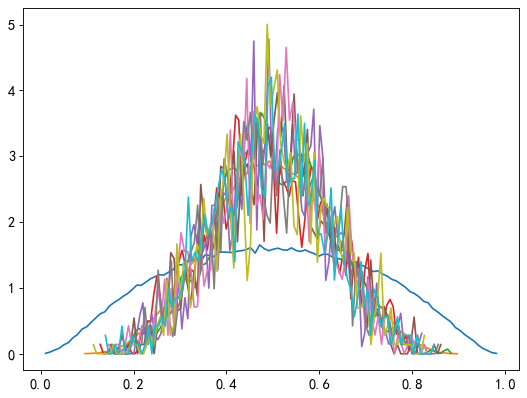

In [14]:
fig, legends = layer_stats(torch.sigmoid, 1.0)
fig.savefig("sigmoid_gain_1.png", dpi=200)

layer  1: mean -0.00, std 0.63
layer  2: mean -0.00, std 0.49
layer  3: mean +0.00, std 0.41
layer  4: mean -0.00, std 0.36
layer  5: mean -0.00, std 0.32
layer  6: mean -0.00, std 0.30
layer  7: mean +0.00, std 0.27
layer  8: mean -0.00, std 0.26
layer  9: mean -0.00, std 0.24
layer 10: mean -0.00, std 0.23


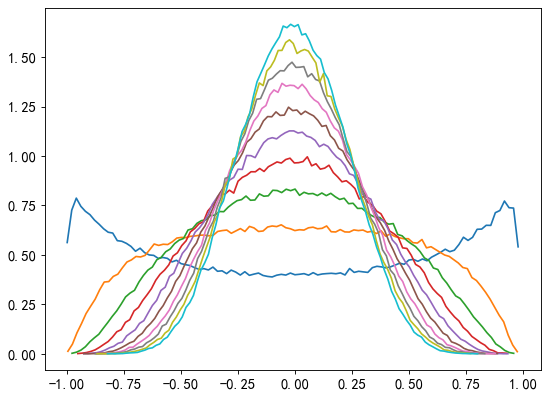

In [15]:
fig, legends = layer_stats(torch.tanh, 1.0)
fig.savefig("tanh_gain_1.png", dpi=200)

layer  1: mean +0.00, std 0.76
layer  2: mean -0.00, std 0.69
layer  3: mean -0.00, std 0.67
layer  4: mean +0.00, std 0.66
layer  5: mean -0.00, std 0.66
layer  6: mean -0.00, std 0.65
layer  7: mean -0.00, std 0.65
layer  8: mean +0.00, std 0.65
layer  9: mean -0.00, std 0.65
layer 10: mean -0.00, std 0.65


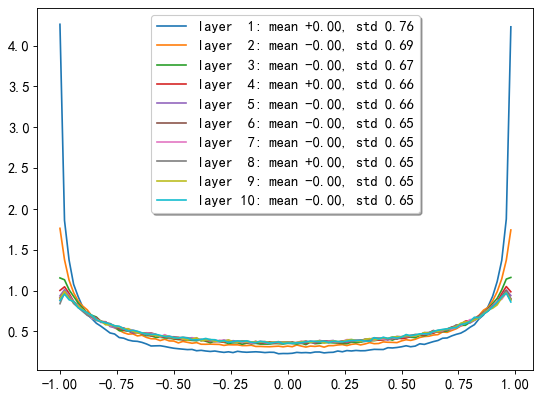

In [16]:
fig, legends = layer_stats(torch.tanh, 5 / 3)
plt.legend(legends, shadow=True)
fig.savefig("tanh_gain_1_6.png", dpi=200)

layer  1: mean -0.00, std 0.72
layer  2: mean +0.00, std 0.63
layer  3: mean +0.00, std 0.59
layer  4: mean +0.00, std 0.57
layer  5: mean -0.00, std 0.56
layer  6: mean +0.00, std 0.56
layer  7: mean +0.00, std 0.55
layer  8: mean +0.00, std 0.55
layer  9: mean -0.00, std 0.55
layer 10: mean -0.00, std 0.55


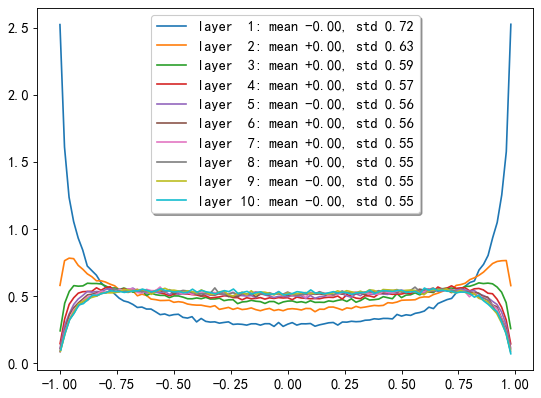

In [17]:
fig, legends = layer_stats(torch.tanh, 1.4)
plt.legend(legends, shadow=True)
fig.savefig("tanh_gain_1_4.png", dpi=200)

layer  1: mean +0.57, std 0.83
layer  2: mean +0.56, std 0.83
layer  3: mean +0.55, std 0.82
layer  4: mean +0.56, std 0.82
layer  5: mean +0.56, std 0.81
layer  6: mean +0.59, std 0.85
layer  7: mean +0.57, std 0.83
layer  8: mean +0.53, std 0.81
layer  9: mean +0.54, std 0.78
layer 10: mean +0.53, std 0.78


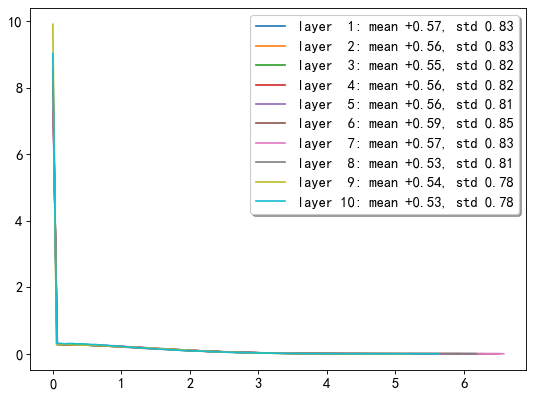

In [18]:
fig, legends = layer_stats(torch.relu, torch.tensor(2).sqrt())
plt.legend(legends, shadow=True)
fig.savefig("relu_gain_1_4.png", dpi=200)